CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from model import Net,model_summary
from utils import has_cuda,which_device,random_image_in_batch

CODE BLOCK: 2

In [3]:
# CUDA?
cuda = has_cuda()

CUDA Available? False


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(28), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1407,), (0.4081,))
    transforms.Normalize((0.1307,), (0.3081,)),            # should be same
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../../data', train=True, download=True, transform=train_transforms)

test_data = datasets.MNIST('../../data', train=True, download=True, transform=train_transforms)

CODE BLOCK: 5

In [6]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}  if cuda else {'batch_size': batch_size, 'shuffle': True,}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs) 

CODE BLOCK: 6

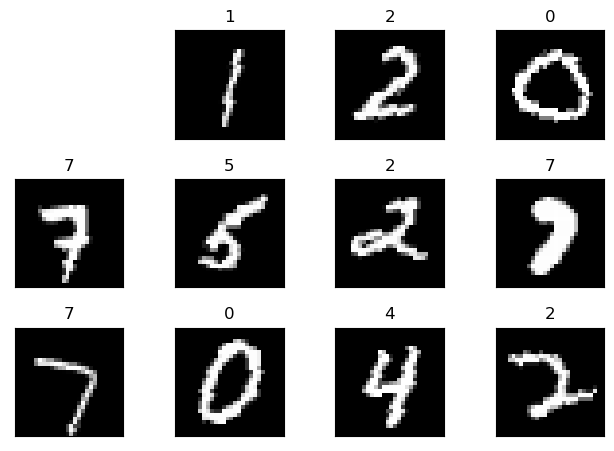

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(1,12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
device = which_device()
print(device)


# model = Net()

CUDA Available? False
cpu


In [10]:
model = Net().to(device)
model_summary(model=model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


CODE BLOCK: 8

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [17]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [18]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)  # epoch is missing
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0776 Batch_id=468 Accuracy=83.50: 100%|███████████████████████████████| 469/469 [02:41<00:00,  2.90it/s]


Test set: Average loss: 0.0990, Accuracy: 58156/60000 (96.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1445 Batch_id=468 Accuracy=97.33: 100%|███████████████████████████████| 469/469 [03:15<00:00,  2.40it/s]


Test set: Average loss: 0.0687, Accuracy: 58731/60000 (97.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0689 Batch_id=468 Accuracy=98.11: 100%|███████████████████████████████| 469/469 [02:58<00:00,  2.63it/s]


Test set: Average loss: 0.0506, Accuracy: 59064/60000 (98.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0525 Batch_id=468 Accuracy=98.50: 100%|███████████████████████████████| 469/469 [03:04<00:00,  2.55it/s]


Test set: Average loss: 0.0443, Accuracy: 59129/60000 (98.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0496 Batch_id=468 Accuracy=98.66: 100%|███████████████████████████████| 469/469 [02:58<00:00,  2.63it/s]


Test set: Average loss: 0.0342, Accuracy: 59360/60000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0399 Batch_id=468 Accuracy=98.86: 100%|███████████████████████████████| 469/469 [02:52<00:00,  2.72it/s]


Test set: Average loss: 0.0367, Accuracy: 59318/60000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1103 Batch_id=468 Accuracy=98.99: 100%|███████████████████████████████| 469/469 [02:45<00:00,  2.83it/s]


Test set: Average loss: 0.0308, Accuracy: 59408/60000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0265 Batch_id=468 Accuracy=99.12: 100%|███████████████████████████████| 469/469 [02:46<00:00,  2.82it/s]


Test set: Average loss: 0.0303, Accuracy: 59411/60000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0005 Batch_id=468 Accuracy=99.09: 100%|███████████████████████████████| 469/469 [02:46<00:00,  2.82it/s]


Test set: Average loss: 0.0222, Accuracy: 59571/60000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0390 Batch_id=468 Accuracy=99.22: 100%|███████████████████████████████| 469/469 [02:47<00:00,  2.81it/s]


Test set: Average loss: 0.0243, Accuracy: 59539/60000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0189 Batch_id=468 Accuracy=99.27: 100%|███████████████████████████████| 469/469 [02:45<00:00,  2.83it/s]


Test set: Average loss: 0.0229, Accuracy: 59563/60000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0552 Batch_id=468 Accuracy=99.28: 100%|███████████████████████████████| 469/469 [02:45<00:00,  2.83it/s]


Test set: Average loss: 0.0206, Accuracy: 59622/60000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0084 Batch_id=468 Accuracy=99.39: 100%|███████████████████████████████| 469/469 [02:45<00:00,  2.83it/s]


Test set: Average loss: 0.0167, Accuracy: 59694/60000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0133 Batch_id=468 Accuracy=99.38: 100%|███████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Test set: Average loss: 0.0172, Accuracy: 59668/60000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0117 Batch_id=468 Accuracy=99.44: 100%|███████████████████████████████| 469/469 [03:06<00:00,  2.51it/s]


Test set: Average loss: 0.0161, Accuracy: 59683/60000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0012 Batch_id=468 Accuracy=99.64: 100%|███████████████████████████████| 469/469 [02:57<00:00,  2.63it/s]


Test set: Average loss: 0.0098, Accuracy: 59807/60000 (99.68%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0053 Batch_id=468 Accuracy=99.72: 100%|███████████████████████████████| 469/469 [02:58<00:00,  2.63it/s]


Test set: Average loss: 0.0093, Accuracy: 59841/60000 (99.73%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0046 Batch_id=468 Accuracy=99.73: 100%|███████████████████████████████| 469/469 [02:53<00:00,  2.70it/s]


Test set: Average loss: 0.0088, Accuracy: 59842/60000 (99.74%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0510 Batch_id=468 Accuracy=99.74: 100%|███████████████████████████████| 469/469 [02:58<00:00,  2.63it/s]


Test set: Average loss: 0.0084, Accuracy: 59855/60000 (99.76%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0002 Batch_id=468 Accuracy=99.72: 100%|███████████████████████████████| 469/469 [02:56<00:00,  2.65it/s]


Test set: Average loss: 0.0085, Accuracy: 59855/60000 (99.76%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

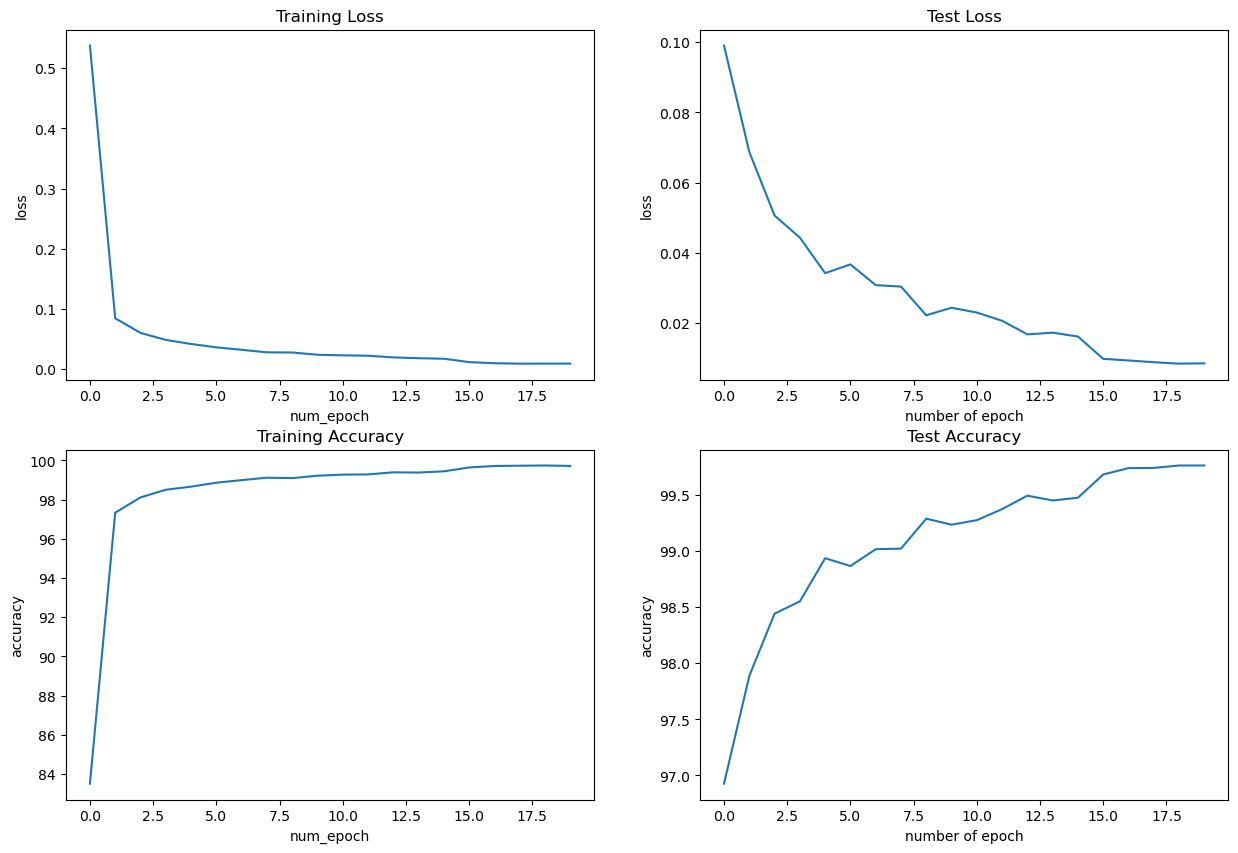

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel('num_epoch')           # num_epochs * len(train_loader)
axs[0, 0].set_ylabel('loss')

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel('num_epoch')            # num_epochs * len(train_loader)
axs[1, 0].set_ylabel('accuracy')


axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel('number of epoch')
axs[0, 1].set_ylabel('loss')


axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel('number of epoch')
axs[1, 1].set_ylabel('accuracy')
plt.show()

**Memory Usage in Colab**

<img src="../pics/memory_usage_Net_model.png"></img>